In [74]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [75]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [76]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [77]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num

In [78]:
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')

In [79]:
precip = airi_dat['precip']

In [80]:
#Load MSE data
mse_dat = xr.open_dataset('/global/scratch/medhap02/ISMData/ERAint_MSE_950.nc')
mse_dat = mse_dat.rename({'G4_LON_2':'lon', 'G4_LAT_1':'lat','MONTHAX':'time'})
mse = mse_dat['MSE']
print(mse_dat)

<xarray.Dataset>
Dimensions:             (LV_ISBL035_35: 1, bnds: 2, lat: 256, lon: 512, time: 456)
Coordinates:
  * lon                 (lon) float32 0.0 0.70312524 ... 358.59387 359.297
  * lat                 (lat) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * LV_ISBL035_35       (LV_ISBL035_35) int32 950
  * time                (time) datetime64[ns] 1979-01-16T12:00:00 ... 2016-12-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    G4_LON_2_bnds       (lon, bnds) float32 ...
    G4_LAT_1_bnds       (lat, bnds) float32 ...
    LV_ISBL035_35_bnds  (LV_ISBL035_35, bnds) int32 ...
    MONTHAX_bnds        (time, bnds) datetime64[ns] ...
    MSE                 (time, LV_ISBL035_35, lat, lon) float64 ...
Attributes:
    history:      PyFerret V7.43 (optimized) 26-Jun-20
    Conventions:  CF-1.6


In [81]:
#Slice MSE data to the same duration as precip and calculate monthly anomalies
mse_subset = mse.sel(time=slice('1979-01-01','2017-01-01'))
mse_clim = mse_subset.groupby('time.month').mean('time')
mse_anomfull = mse_subset.groupby("time.month")-mse_clim
mse_anomfull

<xarray.DataArray 'MSE' (time: 456, LV_ISBL035_35: 1, lat: 256, lon: 512)>
array([[[[ 791.919371, ...,  792.369689],
         ...,
         [-523.322914, ..., -518.583267]]],


       ...,


       [[[ 712.803134, ...,  711.92057 ],
         ...,
         [3524.112481, ..., 3522.678587]]]])
Coordinates:
  * lon            (lon) float32 0.0 0.70312524 1.4062505 ... 358.59387 359.297
  * lat            (lat) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
  * time           (time) datetime64[ns] 1979-01-16T12:00:00 ... 2016-12-16T12:00:00
    month          (time) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [82]:
mse_subset16 = mse_anomfull.sel(time=slice('1979-01-01','1979-12-31'))
mse_subset17 = mse_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
mse_subset18 = mse_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
mse_subset19 = mse_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
mse_subset20 = mse_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
mse_subset21 = mse_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
mse_subset22 = mse_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
mse_subset23 = mse_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

mse_anomtemp = xr.merge([mse_subset16, mse_subset17, mse_subset18, mse_subset19, mse_subset20, 
                   mse_subset21, mse_subset22, mse_subset23])
print(mse_anomtemp)
mse_anom = mse_anomtemp['MSE']

<xarray.Dataset>
Dimensions:        (LV_ISBL035_35: 1, lat: 256, lon: 512, time: 360)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-16T12:00:00 ... 2015-12-16T12:00:00
  * lon            (lon) float32 0.0 0.70312524 1.4062505 ... 358.59387 359.297
  * lat            (lat) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
    month          (time) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    MSE            (time, LV_ISBL035_35, lat, lon) float64 791.9 ... -1.019e+03


In [83]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim

In [84]:
precip_subset16 = precip_anomfull.sel(time=slice('1979-01-01','1979-12-31'))
precip_subset17 = precip_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
precip_subset18 = precip_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
precip_subset19 = precip_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
precip_subset20 = precip_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
precip_subset21 = precip_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
precip_subset22 = precip_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
precip_subset23 = precip_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

precip_anom = xr.merge([precip_subset16, precip_subset17, precip_subset18, precip_subset19, precip_subset20, 
                   precip_subset21, precip_subset22, precip_subset23])
precip_anomtemp = xr.Dataset.to_array(precip_anom)
precip_anom = precip_anom['precip']
print(precip_anom)

<xarray.DataArray 'precip' (time: 360)>
array([ 11.233562,   3.835616,  14.854794, ..., -44.439735, -40.930824,
        13.444523], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-12-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0


In [85]:
junes = np.arange(5,360,12)
julys = np.arange(6,360,12)
augusts = np.arange(7,360, 12)
septembers = np.arange(8,360,12)
precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precipa_jjas = (precipa_june + precipa_july + precipa_august + precipa_september)

In [86]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [87]:
#(10-25n, 75-105e)

latrange = mse_anom.sel(lat = slice(10, 25)).lat
weights1 = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(10, 25), lon = slice(75, 105), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1979-03-01', '2015-03-30'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprildata1 = mse_anom.sel(lat = slice(10, 25), lon = slice(75, 105), time = (mse_anom['time.month']==4))
aprilMSE1 = aprildata1.sel(time = slice('1979-04-01', '2015-04-30'))
aprilmean1 = (aprilMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(10, 25), lon = slice(75, 105), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1979-05-01', '2015-05-30'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data

MSEmamtemp = (marchmean1 + aprilmean1 + maymean1)/3

MSEmam = MSEmamtemp
MSEstd = MSEmam.std()
MSEmean = MSEmam.mean()
MSEmam = (MSEmam - MSEmean)/MSEstd
print(MSEmam)

<xarray.DataArray (time: 30, LV_ISBL035_35: 1)>
array([[-0.505353],
       [-1.07088 ],
       [-0.658925],
       [-0.495106],
       [ 0.048917],
       [-0.896647],
       [-1.61928 ],
       [ 1.419703],
       [-1.759806],
       [ 0.612754],
       [ 1.833469],
       [-1.233793],
       [ 0.159935],
       [-0.081196],
       [ 0.055624],
       [-2.149836],
       [ 1.570492],
       [-0.002945],
       [ 0.583238],
       [ 0.097338],
       [ 0.67176 ],
       [ 0.164995],
       [ 0.673533],
       [-0.294477],
       [ 0.282004],
       [ 2.094978],
       [ 0.086488],
       [-0.01181 ],
       [-0.515589],
       [ 0.940415]])
Coordinates:
  * time           (time) datetime64[ns] 1979-05-16T12:00:00 ... 2015-05-16T12:00:00
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
    month          (time) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0


In [88]:
#(0-25n, 45-70e)
#(20-40n, 70-90e)

latrange = mse_anom.sel(lat = slice(0, 25)).lat
weights = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1979-03-01', '2015-03-30'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprildata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==4))
aprilMSE1 = aprildata1.sel(time = slice('1979-04-01', '2015-04-30'))
aprilmean1 = (aprilMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1979-05-01', '2015-05-30'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data

MSEwest = maymean1 - marchmean1

latrange2 = mse_anom.sel(lat = slice(20, 40)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==3))
marchMSE2 = marchdata2.sel(time = slice('1979-03-01', '2015-03-30'))
marchmean2 = ((marchMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprildata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==4))
aprilMSE2 = aprildata2.sel(time = slice('1979-04-01', '2015-04-30'))
aprilmean2 = ((aprilMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==5))
mayMSE2 = maydata2.sel(time = slice('1979-05-01', '2015-05-30'))
maymean2 = ((mayMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
aprilmean2.time.data = maymean2.time.data

MSEeast = maymean2 - marchmean2

#MSEeast.time.data = MSEwest.time.data

MSEmay_mar = (MSEeast + MSEwest)/2
print(MSEmay_mar)
MSEstd = MSEmay_mar.std()
MSEmean = MSEmay_mar.mean()
MSEmay_mar = (MSEmay_mar - MSEmean)/MSEstd
print(MSEmay_mar)

<xarray.DataArray (time: 30, LV_ISBL035_35: 1)>
array([[ -632.354751],
       [ -972.244131],
       [-1645.796739],
       [   82.160024],
       [ -298.548346],
       [ -243.899724],
       [-3150.871889],
       [ -419.741397],
       [-3013.223347],
       [ 2536.389581],
       [-1508.194668],
       [ 1569.076007],
       [  -11.333617],
       [-2456.074401],
       [-3301.519255],
       [-3357.507971],
       [  841.511468],
       [ 6067.429492],
       [ 2657.642041],
       [  532.790832],
       [  250.324195],
       [-2720.231621],
       [ 1636.701108],
       [ 3117.932991],
       [-1333.12824 ],
       [ 1185.76948 ],
       [ 2603.021379],
       [ -924.350028],
       [ -457.162953],
       [  -93.596685]])
Coordinates:
  * time           (time) datetime64[ns] 1979-05-16T12:00:00 ... 2015-05-16T12:00:00
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
<xarray.DataArray (time: 30, LV_ISBL035_35: 1)>
array([[-0.240962],
       [-0.399361],
       [-0.713257],
       [ 0

In [89]:
precipa_jjas.time.data = maymean1.time.data

msemam = correlation(MSEmam, precipa_jjas, dims='time')
print("MSE mam", msemam.data)
msemamtemp = correlation(MSEmamtemp, precipa_jjas, dims='time')
print("Non standardized MSE MAM", msemamtemp.data)

print()
msemay_mar = correlation(MSEmay_mar, precipa_jjas, dims='time')
print("MSE May - March 2 boxes", msemay_mar.data)
mseeast = correlation(MSEeast, precipa_jjas, dims='time')
print("MSE Right", mseeast.data)
msewest = correlation(MSEwest, precipa_jjas, dims='time')
print("MSE Left", msewest.data)

MSE mam [0.24463817]
Non standardized MSE MAM [0.24463817]

MSE May - March 2 boxes [0.1979125]
MSE Right [0.216085]
MSE Left [0.10656084]


In [90]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

In [91]:
mse_anomalt = mse_anom.squeeze('LV_ISBL035_35')

march = np.arange(2,360,12)
april = np.arange(3,360,12)
may = np.arange(4,360,12)

msea_march = mse_anomalt[march,:,:]
msea_april = mse_anomalt[april,:,:]
msea_may = mse_anomalt[may,:,:]

msea_march.time.data = msea_may.time.data
msea_april.time.data = msea_may.time.data

precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precipa_jjas = precipa_june + precipa_july + precipa_august + precipa_september

msea_mam = msea_march + msea_april + msea_may
msea_may_mar = msea_may - msea_march

precipa_jjas.time.data = msea_mam.time.data

Text(0.5, 1.0, 'Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies')

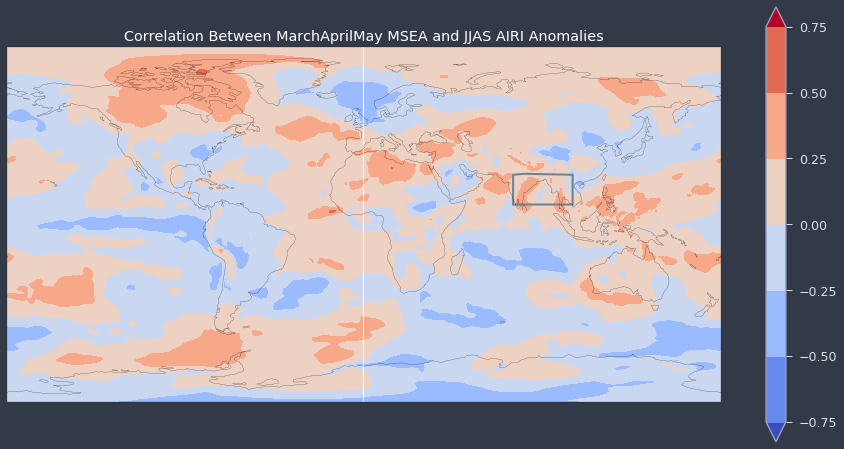

In [92]:
mse_mam_r = correlation(msea_mam,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_mam_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[75,10], width=30, height=15, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(10-25n, 75-105e)
plt.title('Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

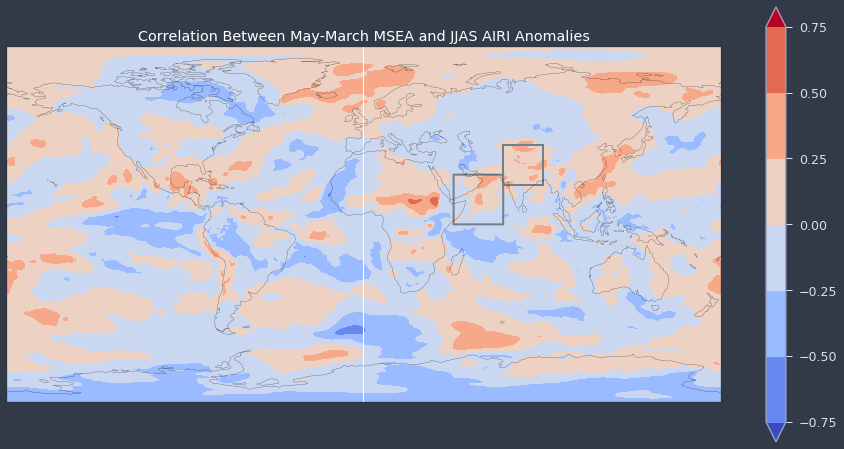

In [94]:
mse_may_mar_r = correlation(msea_may_mar,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[45,0], width=25, height=25, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(0-25n, 45-70e)
ax.add_patch(mpatches.Rectangle(xy=[70,20], width=20, height=20, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(20-40n, 70-90e)
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')